In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
import transfer_functions as H
from scipy.fft import rfft, rfftfreq, irfft
from time import sleep
import sounddevice as sd
from scipy.io.wavfile import write
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
import time

class MyDAQ:
    def __init__(self):
        self.__samplerate = None
        self.__name = None

    @property
    def samplerate(self) -> int:
        return self.__samplerate

    @samplerate.setter
    def samplerate(self, newSamplerate: int) -> None:
        assert isinstance(newSamplerate, int), "Samplerate should be an integer."
        assert newSamplerate > 0, "Samplerate should be positive."
        self.__samplerate = newSamplerate

    @property
    def name(self) -> str:
        return self.__name

    @name.setter
    def name(self, newName: str) -> None:
        assert isinstance(newName, str), "Name should be a string."
        self.__name = newName

    def _addOutputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add output channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ao_channels.add_ao_voltage_chan(channel)
            else:
                task.ao_channels.add_ao_voltage_chan(f"{self.name}/{channel}")

    def _addInputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add input channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ai_channels.add_ai_voltage_chan(channel)
            else:
                task.ai_channels.add_ai_voltage_chan(f"{self.name}/{channel}")

    def _configureChannelTimings(self, task: dx.task.Task, samples: int) -> None:
        """
        Set the correct timings for task based on number of samples
        """
        assert not (self.samplerate is None), "Samplerate should be set first."

        task.timing.cfg_samp_clk_timing(
            self.samplerate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samples,
        )

    @staticmethod
    def convertDurationToSamples(samplerate: int, duration: float) -> int:
        samples = duration * samplerate

        # Round down to nearest integer
        return int(samples)

    @staticmethod
    def convertSamplesToDuration(samplerate: int, samples: int) -> float:
        duration = samples / samplerate

        return duration

    def read(self, duration: float, *channels: str, timeout: float = 300) -> np.ndarray:
        """
        Read from user-specified channels for `duration` seconds
        """

        # Convert duration to samples
        samples = MyDAQ.convertDurationToSamples(self.samplerate, duration)

        # Create read task
        with dx.Task("readOnly") as readTask:
            self._addInputChannels(readTask, channels)
            self._configureChannelTimings(readTask, samples)

            # Now read in data. Use WAIT_INFINITELY to assure ample reading time
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

        return np.asarray(data)

    def write(self, voltages: np.ndarray, *channels: str) -> None:
        """
        Write `voltages` to user-specified channels.
        """
        samples = max(voltages.shape)

        # Create write task
        with dx.Task("writeOnly") as writeTask:
            self._addOutputChannels(writeTask, channels)
            self._configureChannelTimings(writeTask, samples)

            # Now write the data
            writeTask.write(voltages, auto_start=True)

            # Wait for writing to finish
            sleep(samples / self.samplerate + 1 / 1000)
            writeTask.stop()

    def readwrite(
        self,
        voltages: np.ndarray,
        readChannels: str | list[str],
        writeChannels: str | list[str],
        timeout: float = 300,
    ) -> np.ndarray:
        samples = max(voltages.shape)

        with dx.Task("read") as readTask, dx.Task("write") as writeTask:
            self._addOutputChannels(writeTask, writeChannels)
            self._addInputChannels(readTask, readChannels)

            self._configureChannelTimings(writeTask, samples)
            self._configureChannelTimings(readTask, samples)

            # Start writing. Since reading is a blocking function, there
            # is no need to sleep and wait for writing to finish.

            writeTask.write(voltages)
            
            start_time = time.perf_counter()  
            writeTask.start()
            elapsed_time = time.perf_counter() - start_time
            print(f"writeTask.start took {elapsed_time:.6f} seconds.") 

            data = readTask.read(number_of_samples_per_channel=(samples - int(elapsed_time * self.samplerate)), timeout=timeout)

            return np.asarray(data)

    @staticmethod
    def generateWaveform(
        function,
        samplerate: int,
        frequency: float,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)

        wave = function(timeArray, amplitude, frequency, phase)

        return timeArray, wave

    @staticmethod
    def findFunction(function: str):
        match function:
            case "sine":
                return lambda x, A, f, p: A * np.sin(2 * np.pi * f * x + p)
            case "square":
                return lambda x, A, f, p: A * square(2 * np.pi * f * x + p)
            case "sawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p)
            case "isawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0)
            case "triangle":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0.5)
            case _:
                raise ValueError(f"{function} is not a recognized wavefront form")

    @staticmethod
    def getTimeArray(duration: float, samplerate: int) -> np.ndarray:
        steps = MyDAQ.convertDurationToSamples(samplerate, duration)
        return np.linspace(1 / samplerate, duration, steps)

    def __str__(self) -> str:
        """
        Only used for pretty printing of class
        E.g. using `print(MyDAQ)` will neatly print the most important
        properties
        """
        title = f"MyDAQ instance"

        return (
            title
            + f"\n{'=' * len(title)}"
            + f"\nBase name: {self.name}"
            + f"\nSample rate: {self.samplerate}"
        )

    @staticmethod
    def remove_magnitude(complex_coefficients: np.ndarray, threshold=0.1) -> np.ndarray:
        """
        Remove the magnitude information from FFT data while keeping phase intact.
        This sets the magnitude of each frequency component to 1.
        """
        # Get the phase of the complex coefficients
        phase = np.angle(complex_coefficients)

        magnitude = np.abs(complex_coefficients)
        # Recreate the complex coefficients with magnitude 1 but the same phase
        magnitude_removed_coefficients = np.exp(1j * phase) * 0.1*np.max(magnitude) # e^(i*phase)

        return magnitude_removed_coefficients
    
            # Apply the threshold for peak detection
        # normalized_magnitude = np.where(magnitude >= threshold * np.max(magnitude), np.max(magnitude), magnitude)

        # # Recombine the magnitude and phase into a complex array
        # normalized_complex_coefficients = normalized_magnitude * np.exp(1j * phase)

        # return normalized_complex_coefficients
    
    @staticmethod
    def remove_phase(complex_coefficients: np.ndarray) -> np.ndarray:
        """
        Remove phase information from the complex FFT coefficients,
        leaving only the magnitude information.

        Parameters:
        complex_coefficients (np.ndarray): Array of complex FFT coefficients.

        Returns:
        np.ndarray: Modified complex array with only magnitude information.
        """
        # Retain the magnitude and set phase to zero
        magnitude_only = np.abs(complex_coefficients) * np.exp(1j * 0)  # Phase set to 0

        return magnitude_only
    
    @staticmethod
    def integral(x,y):
    #integral functions from scipy will be used to integrate over the datapoints
        return integrate.trapezoid(y, x)

    @staticmethod
    def power(freqs, fft, f, samplesize, delta_f=100):
        """
        Get the integration interval, this is a boolean array of frequencies, which
        is true when a frequency is inside the interval and false otherwise. This is used
        to find the frequencies over which we need to integrate.
        """
        if np.isscalar(f):
            f = [f]
        
        f_num = len(f)
        left_margin = 0
        right_margin = 0
        power_list = []

        normalized_fft = fft / samplesize
        normalized_fft[1:] *= 2

        for i, target_freq in enumerate(f):
            if i > 0:
                left_margin = np.exp(0.5 * np.log(f[i] - f[i - 1]))
            else:
                left_margin = delta_f
            if i < f_num - 1:
                right_margin = np.exp(0.5 * np.log(f[i + 1] - f[i]))
            else:
                right_margin = delta_f
            
            interval = (freqs > target_freq - left_margin) & (freqs < target_freq + right_margin) & (freqs > 0)

            power = integrate.trapezoid(np.abs(normalized_fft[interval])**2, freqs[interval])
            power_list.append(power)

        # Ensure the return is always a NumPy array
        return np.sqrt(np.array(power_list))

    @staticmethod
    def generateMultipleWaveforms(function,
        frequencies: np.ndarray,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        samplerate: int = 200000,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)
        wave = np.zeros(len(timeArray))
        for f in frequencies:
            wave += function(timeArray, amplitude, f, phase)

        return timeArray, wave / np.max(wave) * 4
    
    @staticmethod
    def getPhaseShift(freqs, fft_direct, fft_filter, frequencies):
        valid_indices = freqs > 0
        freqs = freqs[valid_indices]
        fft_direct = fft_direct[valid_indices]
        fft_filter = fft_filter[valid_indices]

        frequencies_indices = np.array([np.abs(freqs - target).argmin() for target in frequencies])
        phaseshifts = []
        for f, i in zip(frequencies, frequencies_indices):
            start = max(i - 30, 0)
            stop = min(i + 30, len(freqs) - 1)

            direct_func = interp1d(np.log(freqs[start:stop]), fft_direct[start:stop])
            filter_func = interp1d(np.log(freqs[start:stop]), fft_filter[start:stop])

            direct_interplolated = direct_func(np.log(f))
            filter_interpolated = filter_func(np.log(f))

            phaseshift = np.rad2deg(np.angle(filter_interpolated / direct_interplolated))
            phaseshifts.append(phaseshift)
        
        return phaseshifts

    @staticmethod
    def getMagnitudePhase(
        data: np.ndarray,
        frequencies: np.ndarray | float = 0.0,
        samplerate: int=200000,
        plots: bool=True,
        res_freq: bool=False,
        cutoff_freq: bool=False
    ) -> tuple[np.ndarray, np.ndarray]:

        direct_data = data[0]
        filter_data = data[1]
        samplesize = len(direct_data)

        direct_fft = np.fft.fft(direct_data)
        filter_fft = np.fft.fft(filter_data)
        freqs = np.fft.fftfreq(samplesize, 1/samplerate)

        direct_powers = MyDAQ.power(freqs, direct_fft, frequencies, samplesize, delta_f=20)
        filter_powers = MyDAQ.power(freqs, filter_fft, frequencies, samplesize, delta_f=20)

        H_magnitudes = filter_powers / direct_powers

        frequencies_indices = np.array([np.abs(freqs - target).argmin() for target in frequencies])

        H_phaseshifts = np.rad2deg(np.angle(filter_fft[frequencies_indices] / direct_fft[frequencies_indices]))

        #H_phaseshifts = MyDAQ.getPhaseShift(freqs, direct_fft, filter_fft, frequencies)

        cutoff_index = np.argmin(np.abs(20 * np.log10(H_magnitudes) + 3))
        cutoff_frequency = frequencies[cutoff_index]

        resonant_index = np.argmax(np.abs(20 * np.log10(H_magnitudes)))
        resonant_frequency = frequencies[resonant_index]

        if plots:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 2, 2]})
                
            ax1.scatter(frequencies, 20 * np.log10(H_magnitudes), label=r'$\frac{A_{out}}{A_{in}}$')
            ax1.set_xscale('log')
            ax1.set_ylabel(r'$20 \log_{10}|H(f)| \, \mathrm{[dB]}$')
            ax1.set_title('Gain of the Black Box')
            if cutoff_freq:
                ax1.axvline(cutoff_frequency, color='red', linestyle='--', label=f'$f_c={round(cutoff_frequency)}$')
            if res_freq:
                ax1.axvline(resonant_frequency, color='orange', linestyle='--', label=f'$f_c={round(resonant_frequency)}$')
            ax1.legend(fontsize=14)
            ax1.grid()

            ax2.scatter(frequencies, H_phaseshifts)
            ax2.set_xscale('log')
            ax2.set_xlabel('Frequency [Hz]')
            ax2.set_ylabel('Phase [Degrees]')
            ax2.set_title('Phase-shift of the Black Box')
            if cutoff_freq:
                ax1.axvline(cutoff_frequency, color='red', linestyle='--', label=f'$f_c={round(cutoff_frequency)}$')
            if res_freq:
                ax1.axvline(resonant_frequency, color='orange', linestyle='--', label=f'$f_c={round(resonant_frequency)}$')
            ax2.axhline(-45, color='purple', linestyle='--', label=f'$-45^\\circ $')
            ax2.legend(fontsize=14)
            ax2.grid()

            ax3 = plt.subplot(133, polar=True)  # Create a polar subplot
            ax3.scatter(np.deg2rad(H_phaseshifts), 20 * np.log10(H_magnitudes), label='Data Points', color='red')
            ax3.set_title('Polar Plot')
            ax3.legend()

            plt.suptitle(f'Bode Plots of the data', fontsize=20)
            plt.tight_layout()
            plt.show()

        
        return H_magnitudes, H_phaseshifts
    
    @staticmethod
    def Q_points_finder(
        freqs: np.ndarray, 
        mags: np.ndarray
    )   -> np.ndarray:
        y_target = np.max(mags) - 3
        interpolator = interp1d(freqs, mags, kind='linear', fill_value="extrapolate")
        def f(x_val):
            return interpolator(x_val) - y_target

        results = root_scalar(f, bracket=[freqs[0], freqs[-1]], method='brentq')
        return results
    
    @staticmethod
    def find_zero_crossings(x, y):
        zero_crossings = []
        for i in range(len(y) - 1):
            if y[i] * y[i + 1] < 0:  # Check for a sign change
                # Linear interpolation to find the x value at y=0
                x_zero = x[i] + (0 - y[i]) * (x[i + 1] - x[i]) / (y[i + 1] - y[i])
                zero_crossings.append(x_zero)
        return zero_crossings

Create MyDAQ class:

In [2]:
daq = MyDAQ()
daq.name = 'MyDAQ1'
daq.samplerate = 200000
read_channel = ['AI0', 'AI1']	
write_channel = 'AO0'

Signal:

In [42]:
duration = 4
amplitude = 5
min_log_freq = np.log10(1/duration)
frequencies = np.logspace(1, 5, 100)
frequencies = np.unique(np.round(frequencies))
frequencies = frequencies[frequencies != 0]

_, signal = daq.generateMultipleWaveforms(function='sine', frequencies=frequencies, duration=duration, amplitude=amplitude, phase=0)

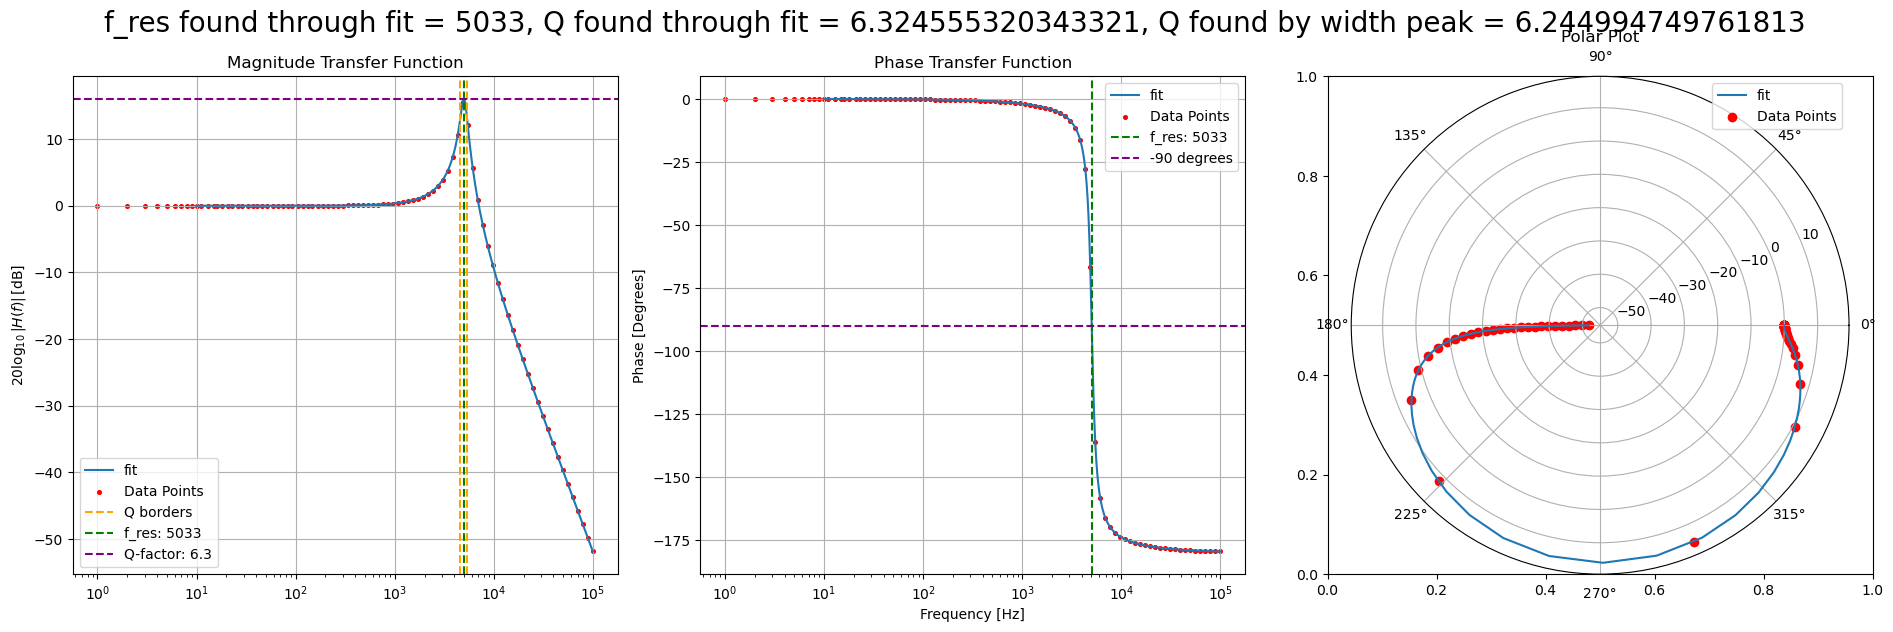

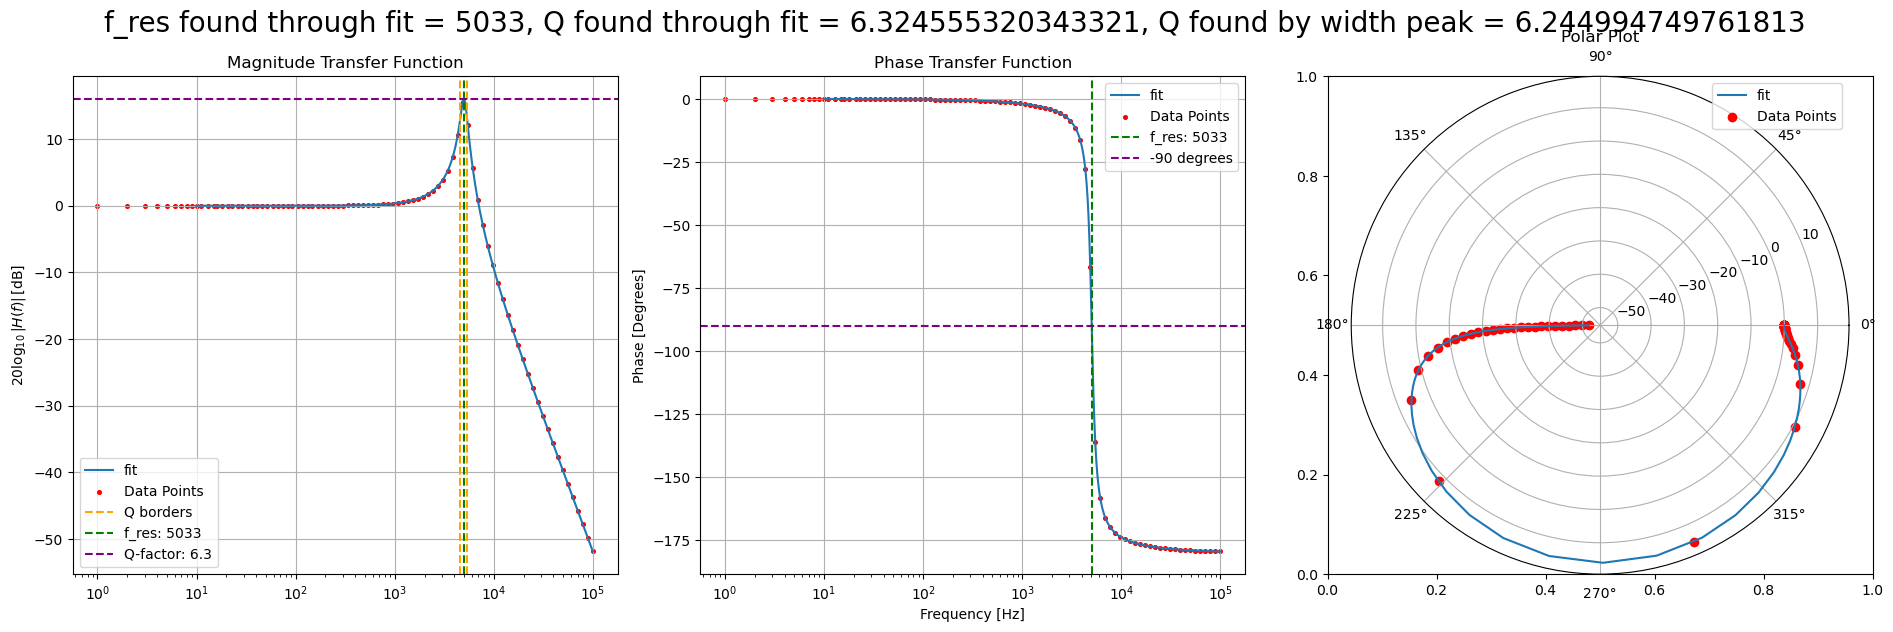

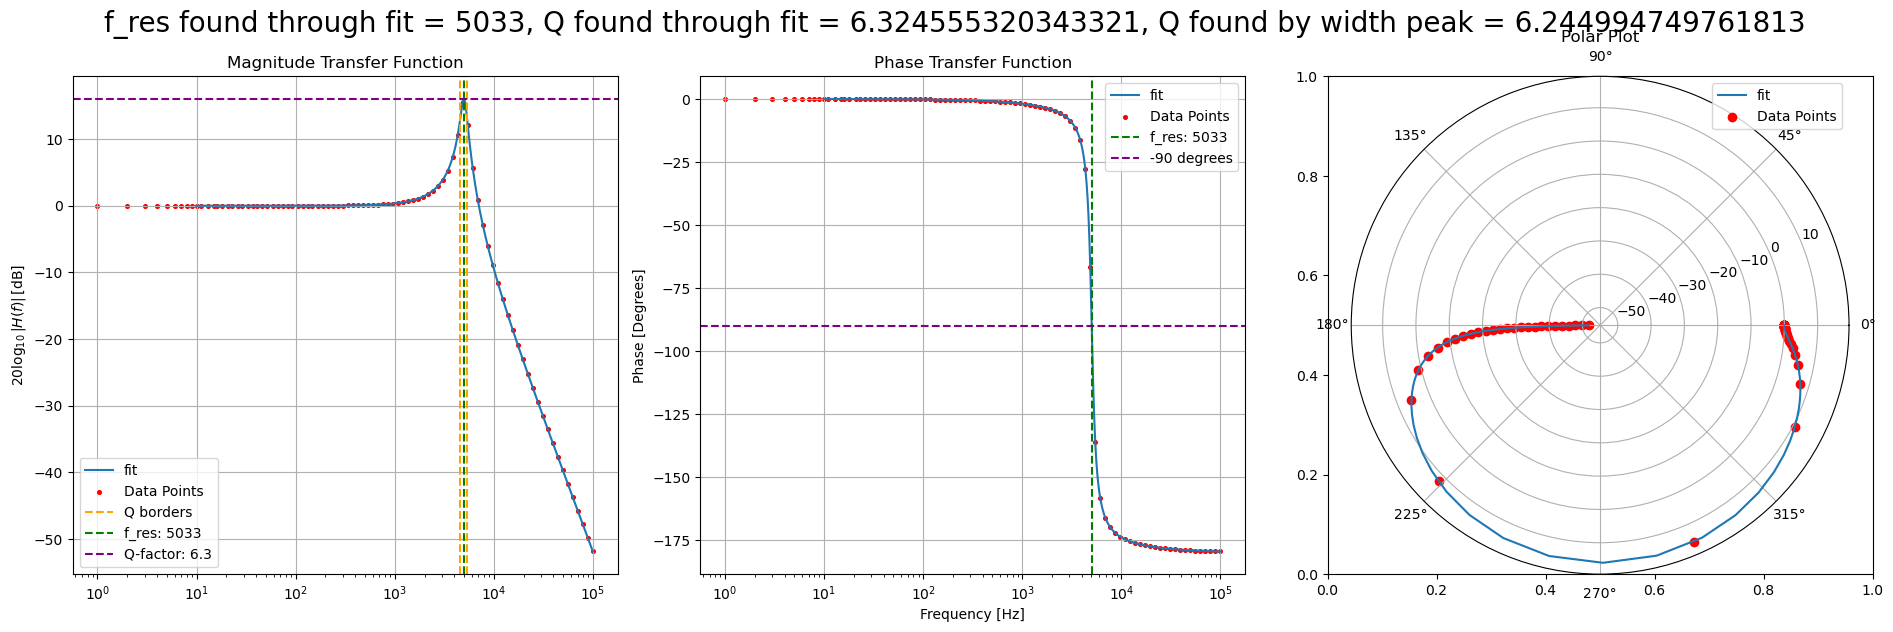

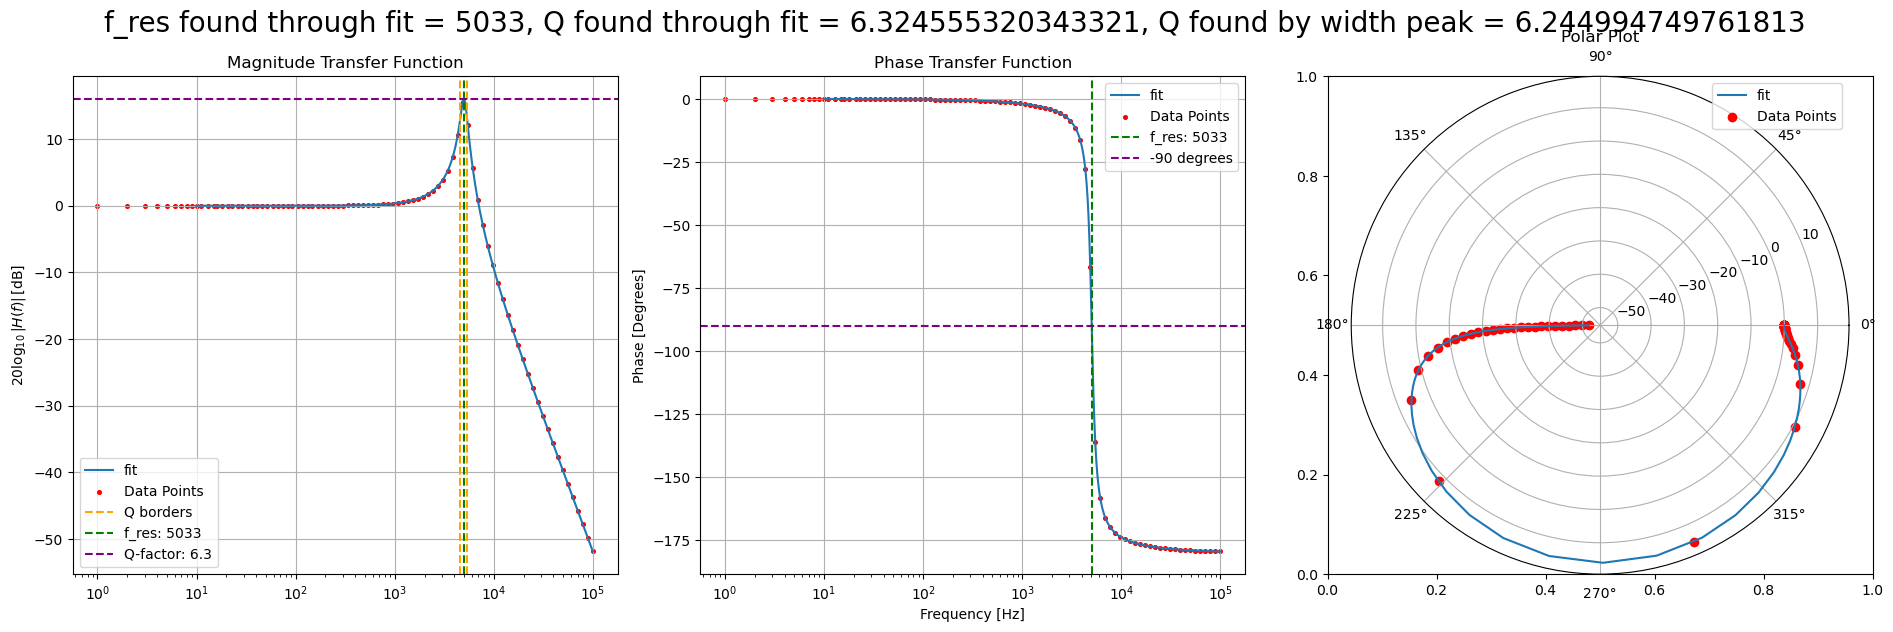

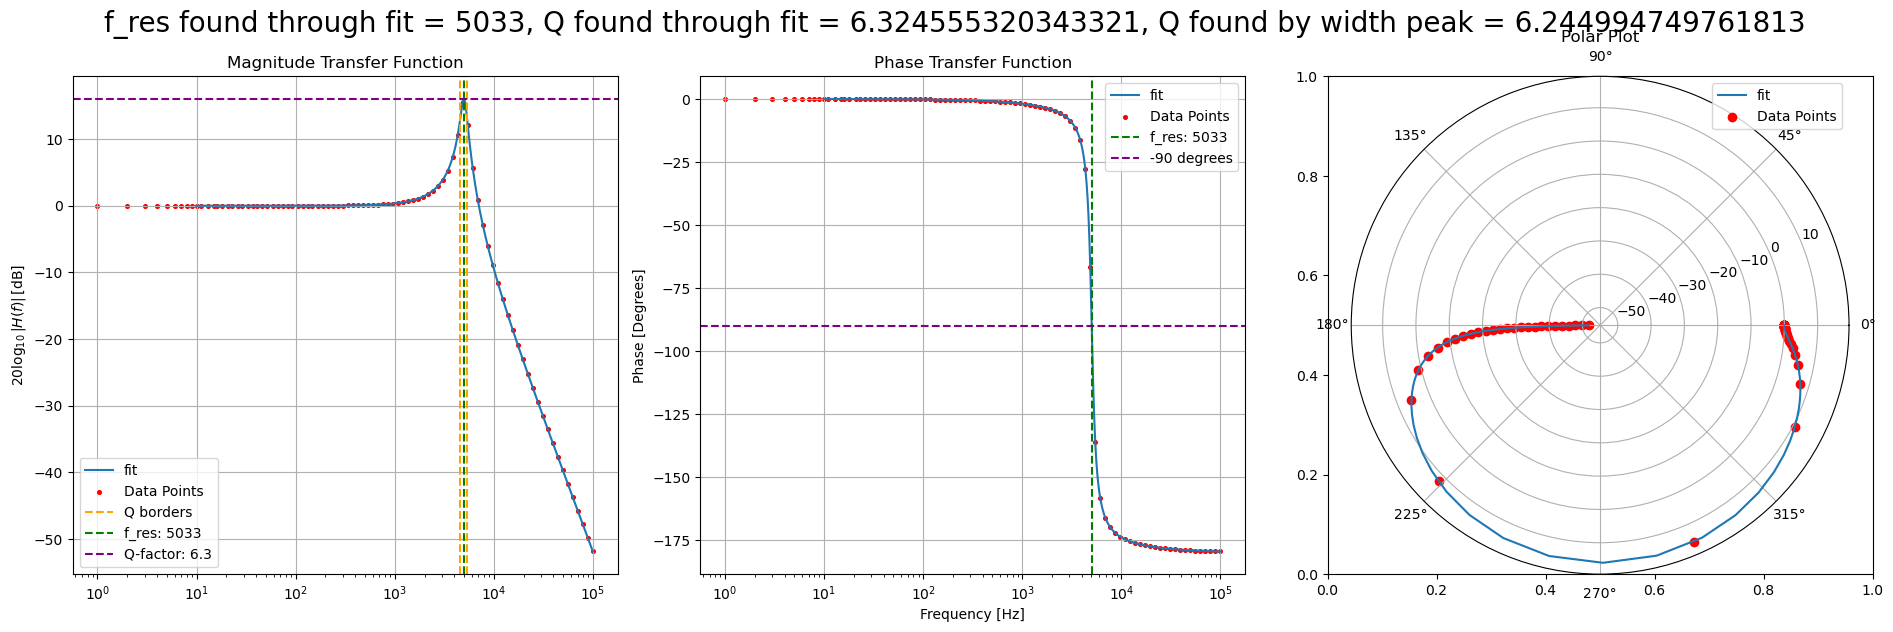

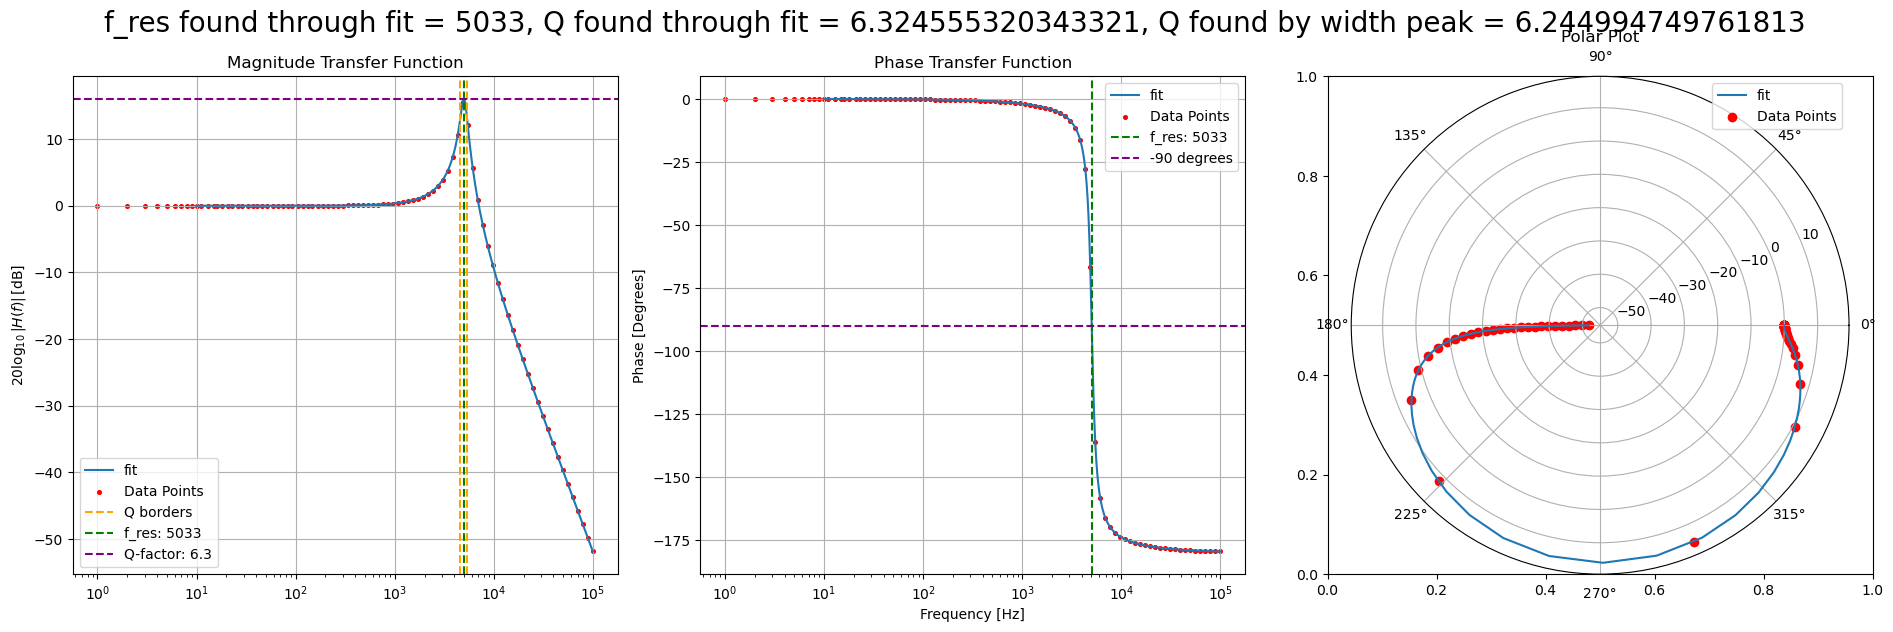

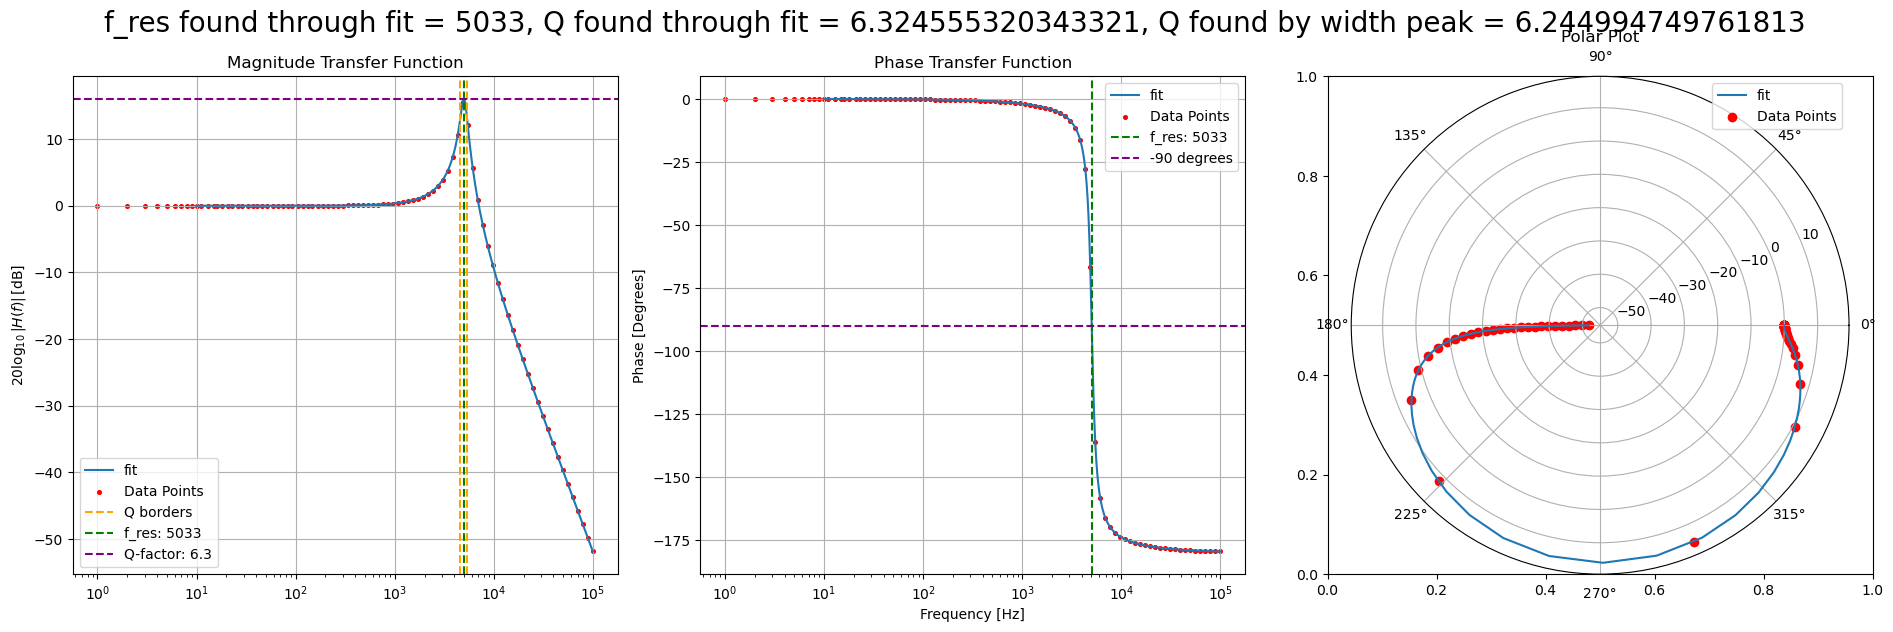

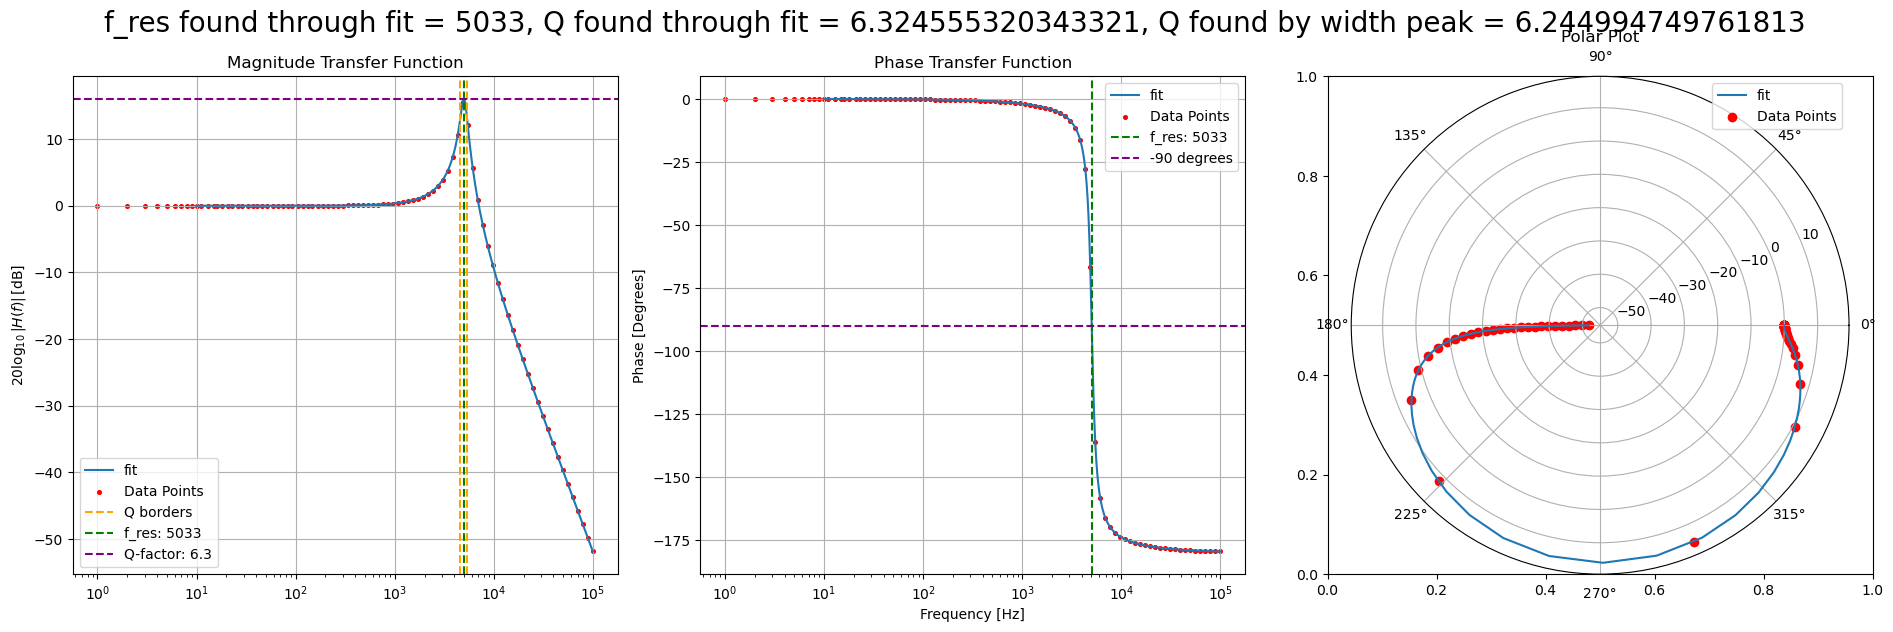

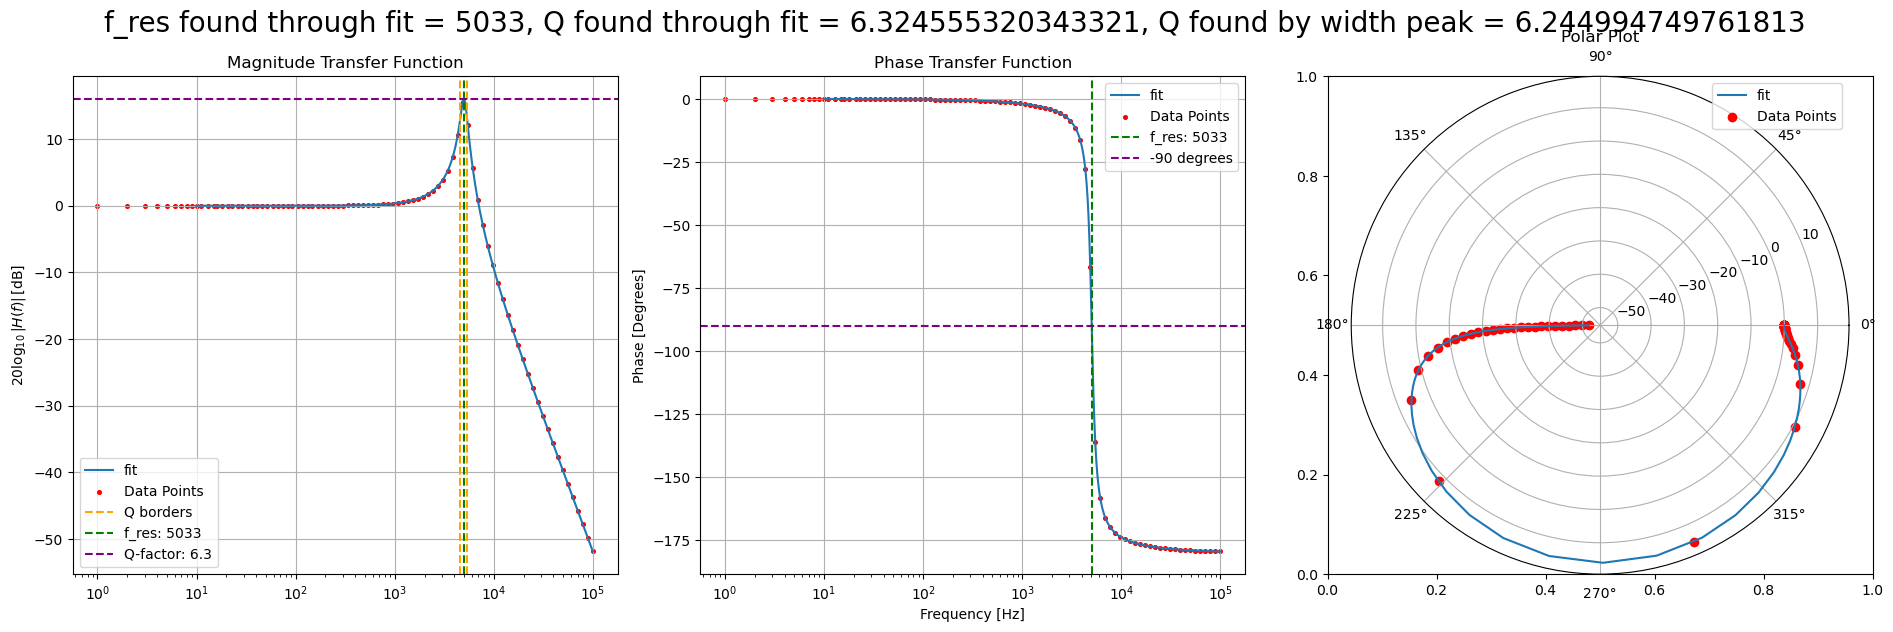

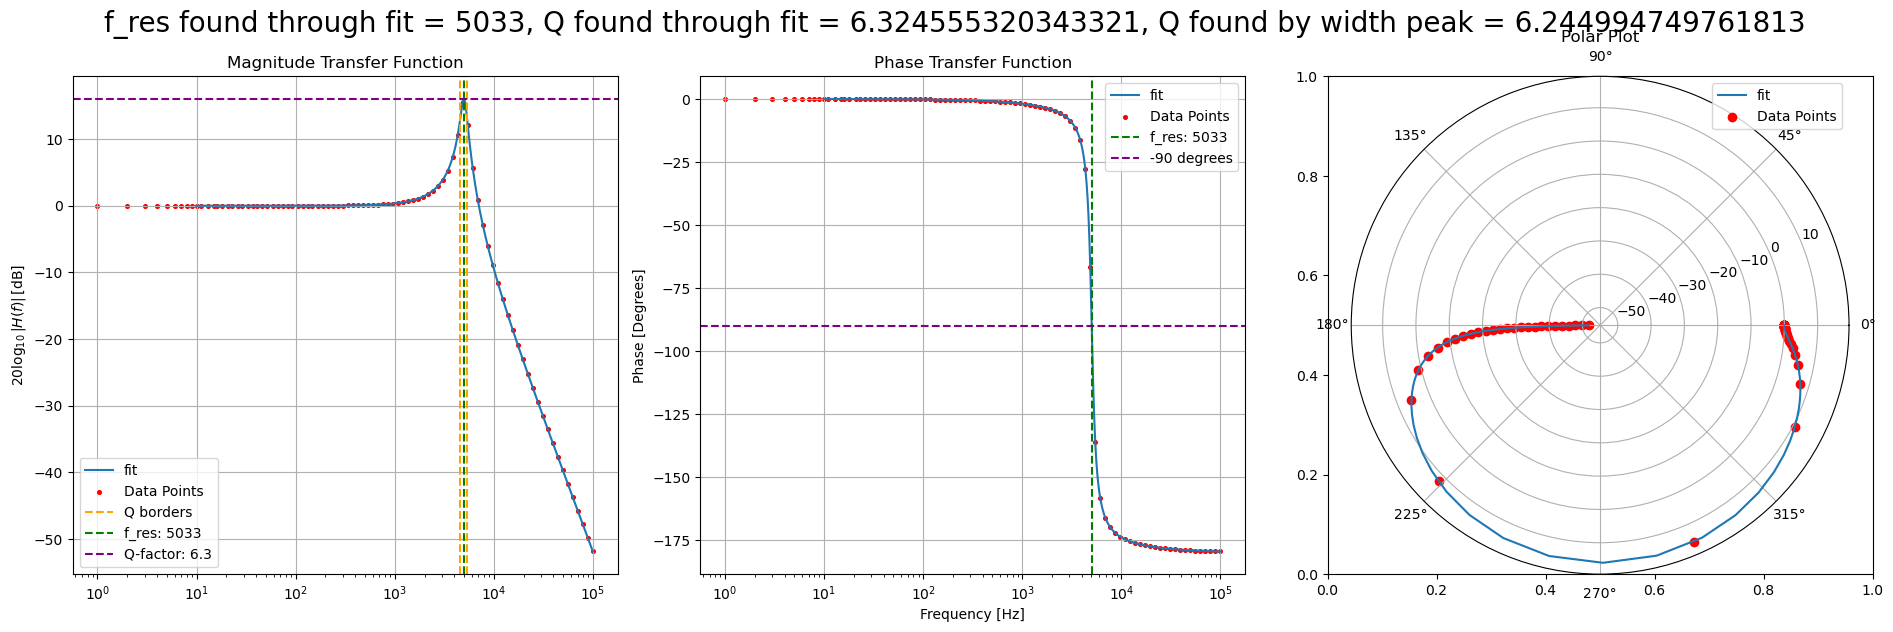

Q_fit: Mean = 6.3246, Std Dev = 0.0000
Q_width_fit: Mean = 6.2450, Std Dev = 0.0000
f_res_fit: Mean = 5032.9212, Std Dev = 0.0000


In [4]:
def model(f, Q, f_res):
    return 1 / np.sqrt(
        (1 - f**2 / f_res**2)**2 + 
        (f / (f_res * Q))**2
    )

def negative_model(f):
    return -model(f, Q_fit_list[-1], f_res_fit_list[-1])

def root_function(f, Q, f_res, target):
    return model (f, Q, f_res) - target

def H_func(f, Q, f_res):
    omega = f * 2 * np.pi
    omega_0 = f_res * 2 * np.pi
    numerator = 1
    denominator = 1 - omega**2 / omega_0**2 + 1j * omega / (omega_0 * Q)
    return numerator / denominator

figscale = 0.8

freqs = np.logspace(1, 5, 500)

Q_fit_list = []
Q_width_fit_list = []
f_res_fit_list = []

for _ in range(0, 10):
    data_measure = daq.readwrite(signal, read_channel, write_channel)
    H_magnitudes, H_phaseshifts = daq.getMagnitudePhase(data_measure, frequencies, res_freq=True, cutoff_freq=True, samplerate=daq.samplerate, plots=False)

    initial_guess = [6, 1000]
    params, pcov = curve_fit(model, frequencies, H_magnitudes, p0=initial_guess)
    Q_fit_list.append(np.abs(params[0]))
    f_res_fit_list.append(params[1])
    peak_coords = minimize_scalar(negative_model, bounds=(freqs[0], freqs[-1]))

    target = 1 / np.sqrt(2) * model(peak_coords.x, Q_fit_list[-1], f_res_fit_list[-1])

    Q_coord_left = root_scalar(root_function, args=(Q_fit_list[-1], f_res_fit_list[-1], target), bracket=(freqs[0], peak_coords.x), method='brentq')
    Q_coord_right = root_scalar(root_function, args=(Q_fit_list[-1], f_res_fit_list[-1], target), bracket=(peak_coords.x, freqs[-1]), method='brentq')

    Q_width_fit_list.append(peak_coords.x / (Q_coord_right.root - Q_coord_left.root))


    #plots

    H_values = H_func(freqs, Q_fit_list[-1], f_res_fit_list[-1])
    phi_values = np.angle(H_values)

    f_res = params[1]
    Q = np.abs(params[0])

    max = np.max(20 * np.log10(np.abs(H_values)))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(figscale * 24, figscale * 8), gridspec_kw={'width_ratios': [2, 2, 2]})


    ax1.plot(freqs, 20 * np.log10(np.abs(H_values)), label=f'fit')
    ax1.scatter(frequencies, 20 * np.log10(H_magnitudes), color='red', label='Data Points', s=7)
    ax1.set_xscale('log')
    ax1.set_title('Magnitude Transfer Function')   
    ax1.axvline(Q_coord_left.root, color='orange', linestyle='--', label='Q borders')
    ax1.axvline(Q_coord_right.root, color='orange', linestyle='--')
    ax1.axvline(f_res, color='green', linestyle='--', label=f'f_res: {round(params[1])}')
    ax1.axhline(20 * np.log10(Q), color='purple', linestyle='--', label=f'Q-factor: {round(Q, 1)}')
    ax1.set_ylabel(r'$20 \log_{10}|H(f)| \, \mathrm{[dB]}$')
    ax1.legend()
    ax1.grid()
    
    # Plot phase response
    ax2.plot(freqs, np.rad2deg(phi_values), label=f'fit')
    ax2.scatter(frequencies, H_phaseshifts, color='red', label='Data Points', s=7)
    ax2.set_xscale('log')
    ax2.set_title('Phase Transfer Function')
    ax2.axvline(f_res, color='green', linestyle='--', label=f'f_res: {round(f_res)}')
    ax2.axhline(-90, color='purple', linestyle='--', label=f'-90 degrees')

    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Phase [Degrees]')
    ax2.legend()
    ax2.grid()

    ax3 = plt.subplot(133, polar=True)  # Create a polar subplot
    ax3.plot(phi_values, 20 * np.log10(np.abs(H_values)), label=f'fit')
    ax3.scatter(np.deg2rad(H_phaseshifts), 20 * np.log10(H_magnitudes), label='Data Points', color='red')
    ax3.set_title(f'Polar Plot')
    ax3.legend()
    
    # Show and save the plot
    plt.suptitle(f"f_res found through fit = {round(f_res)}, Q found through fit = {Q}, Q found by width peak = {Q_width_fit_list[-1]}", fontsize=20)
    plt.tight_layout()

    plt.show()


Q_fit_mean = np.mean(Q_fit_list)
Q_fit_std = np.std(Q_fit_list)

Q_width_fit_mean = np.mean(Q_width_fit_list)
Q_width_fit_std = np.std(Q_width_fit_list)

f_res_fit_mean = np.mean(f_res_fit_list)
f_res_fit_std = np.std(f_res_fit_list)

print(f"Q_fit: Mean = {Q_fit_mean:.4f}, Std Dev = {Q_fit_std:.4f}")
print(f"Q_width_fit: Mean = {Q_width_fit_mean:.4f}, Std Dev = {Q_width_fit_std:.4f}")
print(f"f_res_fit: Mean = {f_res_fit_mean:.4f}, Std Dev = {f_res_fit_std:.4f}")

Theoretical:

In [3]:
duration = 4
amplitude = 5
min_log_freq = np.log10(1/duration)
frequencies = np.logspace(0, 5, 100)
frequencies = np.unique(np.round(frequencies))
frequencies = frequencies[frequencies != 0]

print(frequencies[:20])

R = 50
C = 1e-7
L = 1e-2

t, data = daq.generateMultipleWaveforms(function='sine', frequencies=frequencies, duration=duration, amplitude=amplitude, phase=0, samplerate=daq.samplerate)

fft = np.fft.fft(data)
freqs = np.fft.fftfreq(len(data), 1/daq.samplerate)

H_values = H.RLC_sC(freqs, R, L, C)
filtered_fft = fft * H_values

AI1_data = np.real(np.fft.ifft(filtered_fft))
AI0_data = data

data_theoretical = np.array([AI0_data, AI1_data])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 15. 16. 18. 21. 23. 26.
 29. 33.]


Load:

In [14]:
data_loaded = np.load('meting.npy')

Process data:

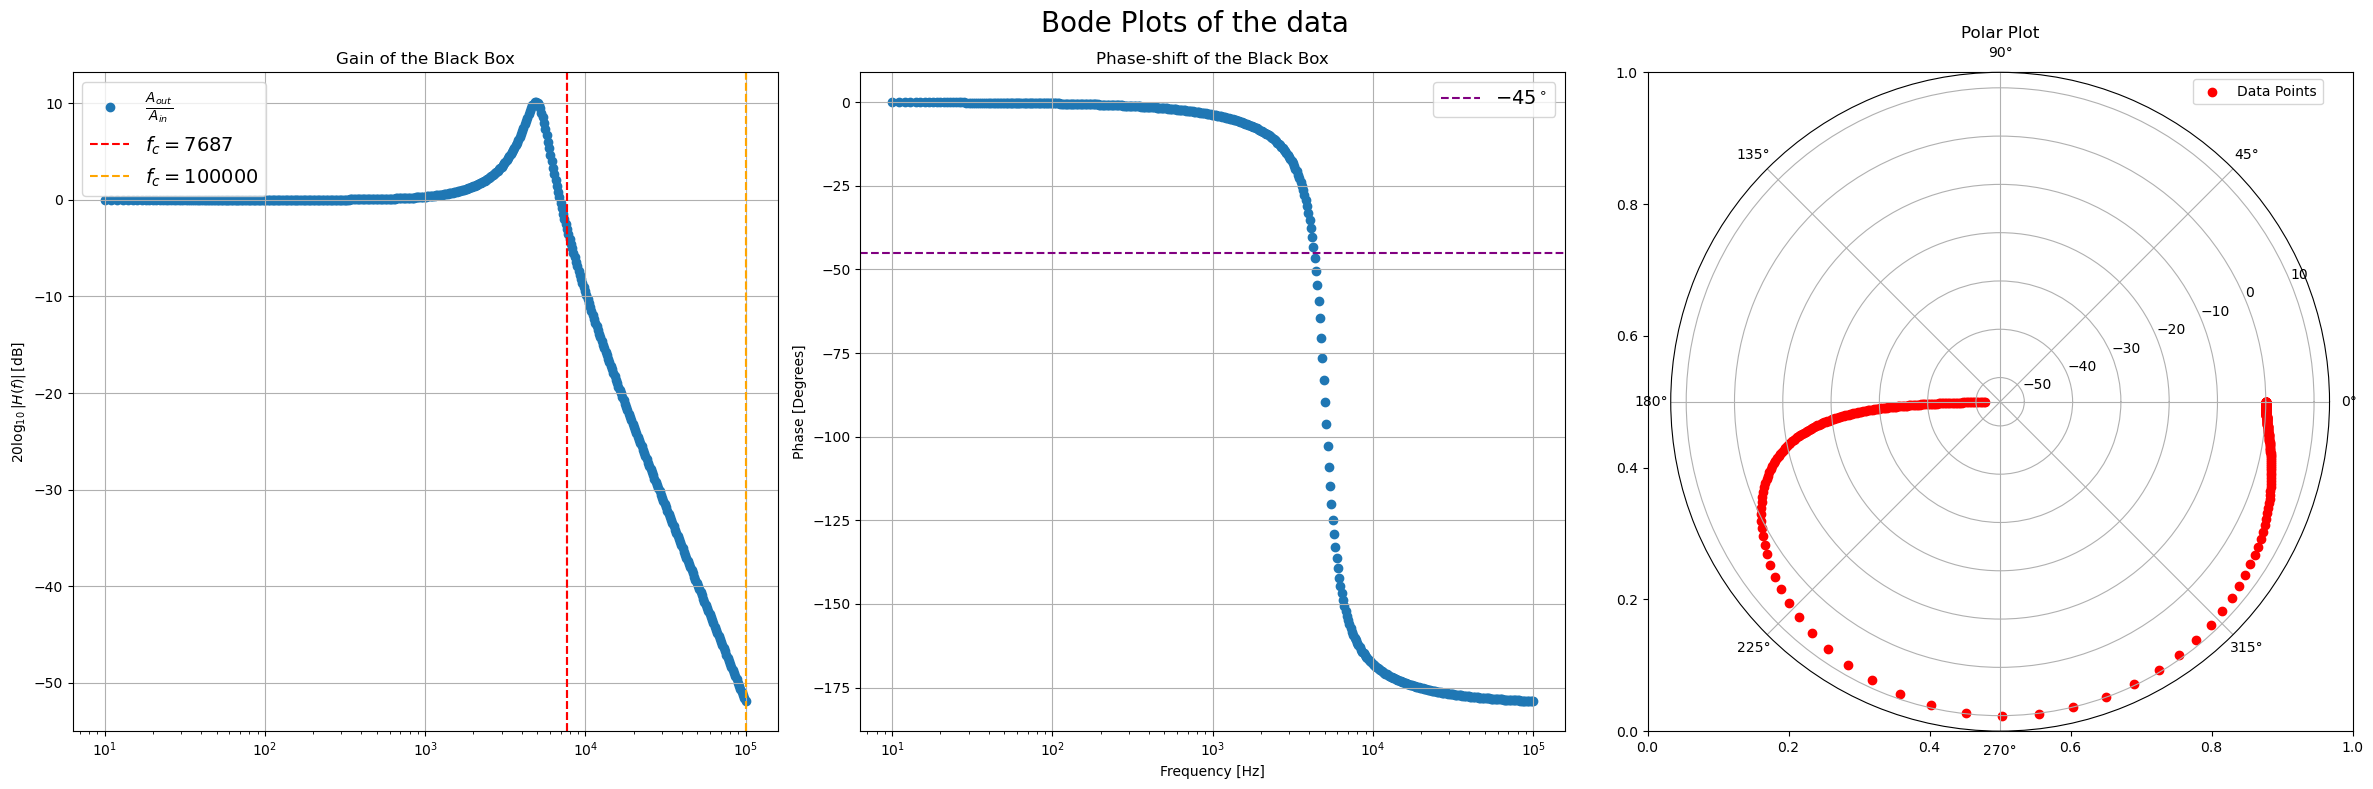

In [15]:
H_magnitudes, H_phaseshifts = daq.getMagnitudePhase(data_theoretical, frequencies, res_freq=True, cutoff_freq=True, samplerate=daq.samplerate)

Bode plots of all types:

1631.23736589601 1453.0403018990419
params:  [-3.16227766e+00  5.03292121e+03] true Q and f_res:  3.162277660168379 5032.921210448703


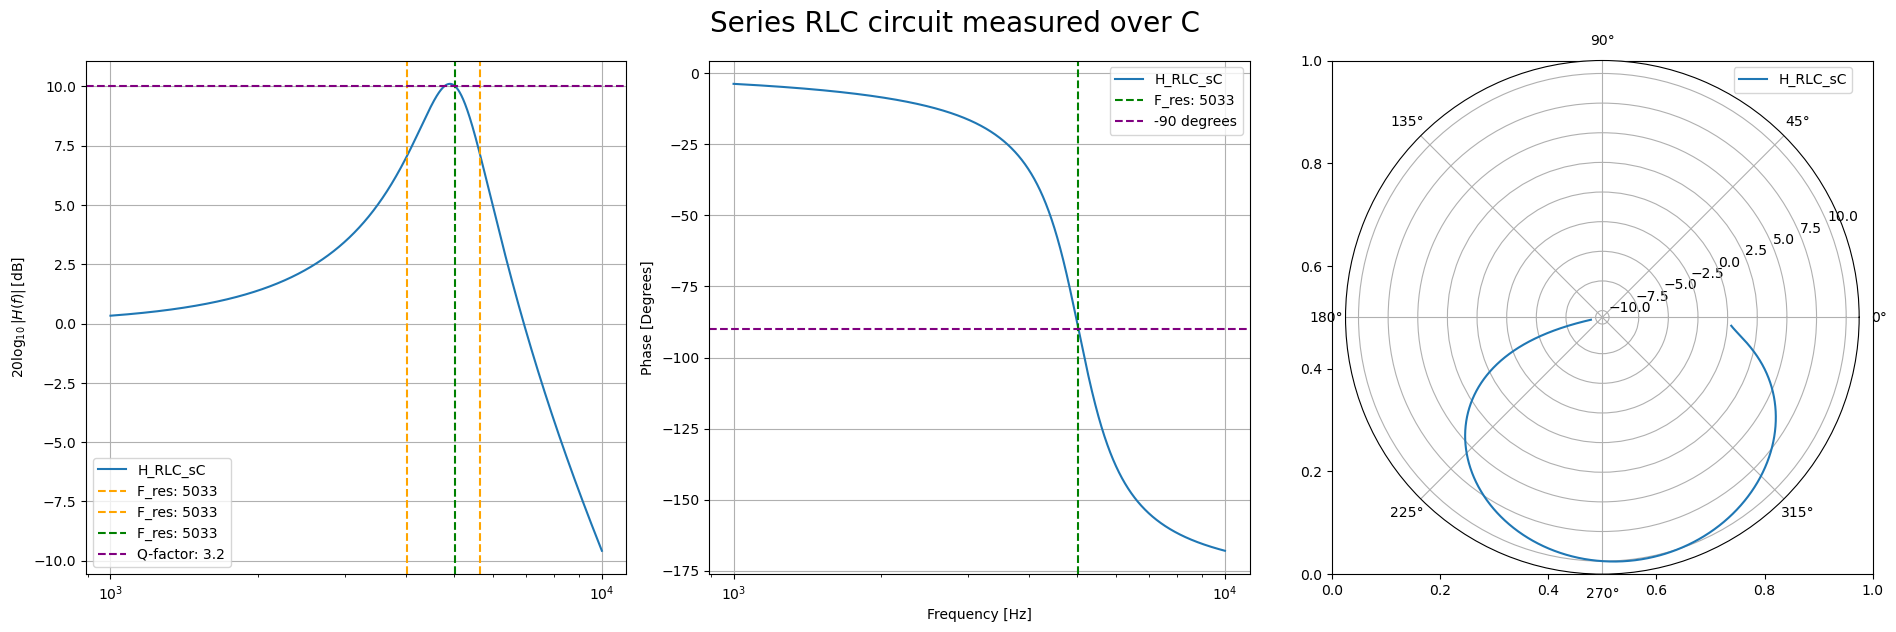

In [16]:
figscale = 0.8
def model(f, Q, f_res):
    return 1 / np.sqrt(
        (1 - f**2 / f_res**2)**2 + 
        (f / (f_res * Q))**2
    )
all_list = [H.RC_C, H.RCRC_CC, H.RLC_sC, H.RLC_sRC, H.RLC_pC, H.RLC_pRL, H.RL_R, H.CL_C, H.RC_R, H.RCRC_RR, H.RLC_sL, H.RLC_sRL, H.RLC_pL, H.RLC_pRC, H.RL_L, H.CL_L, H.RLC_sR, H.RLC_sLC, H.RLC_pR, H.RLC_pLC]

freqs = np.logspace(3, 4, 5000)
#freqs = np.unique(np.round(freqs))
#freqs = freqs[freqs != 0]
R = 100
C = 1e-7
L = 1e-2

omega_0 = 1 / np.sqrt(L * C)
f_res = omega_0 / ( 2 * np.pi )
Q = omega_0 * L / R
delta_f = f_res / Q


H_list = [H.RLC_sC]
for i in range(0, len(H_list)):
    H_values = H_list[i](freqs, R, L, C)
    
    max = np.max(20 * np.log10(np.abs(H_values)))

    phi_values = np.angle(H_values)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(figscale * 24, figscale * 8), gridspec_kw={'width_ratios': [2, 2, 2]})

    crossings = daq.find_zero_crossings(freqs, 20 * np.log10(np.abs(H_values)) - max + 3)

    print(crossings[1] - crossings[0], 10**Q)


    initial_guess = [6, 1000]
    params, pcov = curve_fit(model, frequencies, H_magnitudes, p0=initial_guess)

    print('params: ', params, 'true Q and f_res: ', Q, f_res)

    ax1.plot(freqs, 20 * np.log10(np.abs(H_values)), label=f'H_{H_list[i].__name__}')
    #ax1.scatter(frequencies, 20 * np.log10(H_magnitudes))
    ax1.set_xscale('log')
    #ax1.set_title('Magnitude Transfer Function')   
    ax1.axvline(crossings[0], color='orange', linestyle='--', label=f'F_res: {round(f_res)}')
    ax1.axvline(crossings[1], color='orange', linestyle='--', label=f'F_res: {round(f_res)}')
    #ax1.axhline(20 * np.log10(max * 0.707), color='pink')
    ax1.axvline(f_res, color='green', linestyle='--', label=f'F_res: {round(f_res)}')
    ax1.axhline(20 * np.log10(Q), color='purple', linestyle='--', label=f'Q-factor: {round(Q, 1)}')
    ax1.set_ylabel(r'$20 \log_{10}|H(f)| \, \mathrm{[dB]}$')
    ax1.legend()
    ax1.grid()
    
    # Plot phase response
    ax2.plot(freqs, np.rad2deg(phi_values), label=f'H_{H_list[i].__name__}')
    #ax2.scatter(frequencies, H_phaseshifts)
    ax2.set_xscale('log')
    #ax2.set_title('Phase Transfer Function')
    ax2.axvline(f_res, color='green', linestyle='--', label=f'F_res: {round(f_res)}')
    ax2.axhline(-90, color='purple', linestyle='--', label=f'-90 degrees')

    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Phase [Degrees]')
    ax2.legend()
    ax2.grid()

    ax3 = plt.subplot(133, polar=True)  # Create a polar subplot
    ax3.plot(phi_values, 20 * np.log10(np.abs(H_values)), label=f'H_{H_list[i].__name__}')
    #ax3.scatter(np.deg2rad(H_phaseshifts), 20 * np.log10(H_magnitudes), label='Data Points', color='red')
    #ax3.set_title(f'Polar Plot')
    ax3.legend()
    
    # Show and save the plot
    plt.suptitle(H.function_metadata[H_list[i].__name__]["description"], fontsize=20)
    plt.tight_layout()

    plt.show()